['b_coeffs', 'a_coeffs']


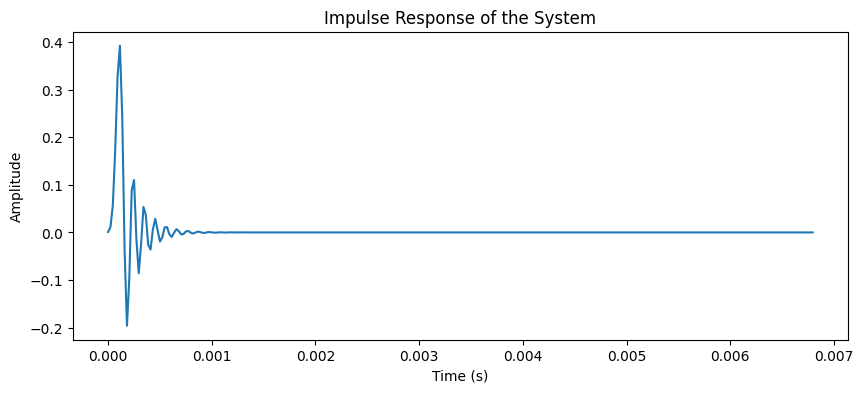

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import stft
import soundfile as sf



# Diese Funktion implementiert die Faltung ( engl . convolution ) zweier
# endlicher Signale gegeben als numpy - Array . Hat x die L ä nge N und h die
# L ä nge M , dann sollte das resultierende Signal eine L ä nge von N +M -1 haben .
# : param x : Eingangssignal als numpy - Array ( L ä nge N )
# : param h : Impulsantwort als numpy - Array ( L ä nge M )
# : return : Ausgangssignal als numpy - Array ( L ä nge N +M -1)

def convolve_sequences ( x : np.ndarray , h : np.ndarray ) -> np.ndarray :
    N = x.shape[0]
    M = h.shape[0]
    print(N, M)
    y = np.zeros( N + M - 1 )
    for n in range( N + M - 1 ) :
        for k in range ( M ) :
            if 0 <= n - k < N :
                y [ n ] += x [ n - k ] * h [ k ]
    return y

import numpy as np

def eval_diff_eq(x: np.ndarray, b_coeffs: np.ndarray, a_coeffs: np.ndarray, max_out: int) -> np.ndarray:
    # Initialize the output array with zeros
    y = np.zeros(max_out)

    # M is the number of feed-forward delays (from b)
    # N is the number of feedback delays (from a)
    M = len(b_coeffs) - 1
    N = len(a_coeffs)

    for n in range(max_out):
        # 1. Non-recursive part: Sum of b[k] * x[n-k]
        for k in range(M + 1):
            if n - k >= 0 and n - k < len(x):
                y[n] += b_coeffs[k] * x[n - k]

        # 2. Recursive part: Subtract Sum of a[k] * y[n-k]
        # Note: In the ARMA formula, a1 corresponds to the delay y(n-1)
        for k in range(1, N + 1):
            if n - k >= 0:
                y[n] -= a_coeffs[k-1] * y[n - k]

    return y


# Define parameters
x_test = np.array([1, 2, 0, 2, 1])
b_test = np.array([0.25, 0.5, 0.25])
a_test = np.array([0.5])

data = np.load("../results/coeffs.npz")
print(data.files)
a_coeffs = data['a_coeffs']
b_coeffs = data['b_coeffs']



impulse = np.zeros(300)
impulse[0] = 1.0
hValues = eval_diff_eq(x=impulse, b_coeffs=b_coeffs, a_coeffs=a_coeffs, max_out=300)


fs = 44000
t = t = np.arange(len(hValues)) / fs
plt.figure(figsize=(10, 4))
plt.plot(t, hValues)
plt.xlabel("Time (s)")
plt.ylabel('Amplitude')
plt.title('Impulse Response of the System')
plt.show()


# plt.plot(t, hValues)
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')
# plt.title('Impulse Response of the System')
# plt.show()



45466 300


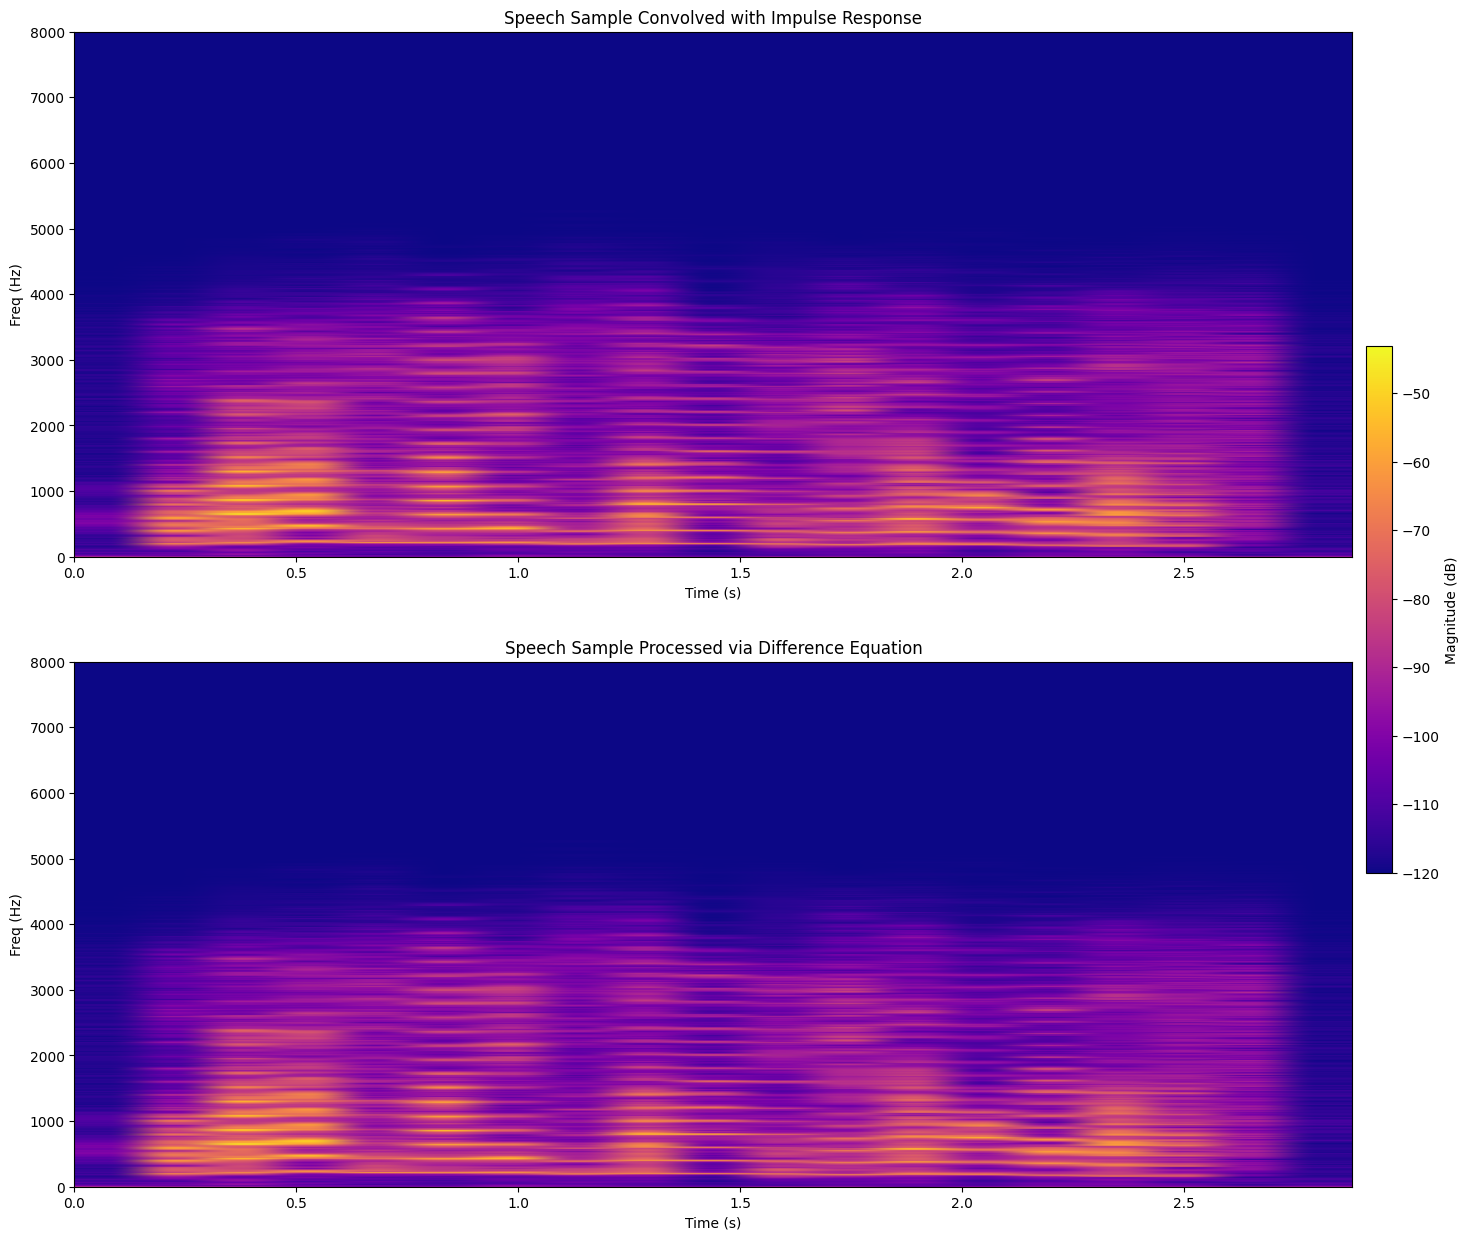

In [4]:
signal, fs = sf.read("../data/speech1.wav")

convolved_signal = convolve_sequences(signal, hValues)
diff_eq_signal = eval_diff_eq(signal, b_coeffs, a_coeffs, len(signal) + len(hValues) - 1)

t = np.linspace(0, len(convolved_signal) / fs, len(convolved_signal))


segmentLength = int(fs / 100 * 32)
overlap = int(segmentLength / 2)
convolved_FreqArray, convolved_TimeArray, convolved_Stft = stft(convolved_signal,fs= fs, nperseg=segmentLength, noverlap=overlap, window="hann")
convolved_magnitude = np.abs(convolved_Stft)
convolved_magnitude_db = 20 * np.log10(convolved_magnitude + 1e-6)

diff_eq_FreqArray, diff_eq_TimeArray, diff_eq_Stft = stft(diff_eq_signal,fs= fs, nperseg=segmentLength, noverlap=overlap, window="hann")
diff_eq_magnitude = np.abs(diff_eq_Stft)
diff_eq_magnitude_db = 20 * np.log10(diff_eq_magnitude + 1e-6)


fig, axs = plt.subplots(2, 1, figsize=(17, 15), sharex=False)

axs[0].imshow(convolved_magnitude_db,
              origin='lower',
              aspect='auto',
              extent=[convolved_TimeArray[0], convolved_TimeArray[-1], convolved_FreqArray[0], convolved_FreqArray[-1]],
              cmap='plasma')
axs[0].set_ylabel("Freq (Hz)")
axs[0].set_xlabel("Time (s)")
axs[0].set_title("Speech Sample Convolved with Impulse Response")

axs[1].imshow(diff_eq_magnitude_db,
              origin='lower',
              aspect='auto',
              extent=[diff_eq_TimeArray[0], diff_eq_TimeArray[-1], diff_eq_FreqArray[0], diff_eq_FreqArray[-1]],
              cmap='plasma')
axs[1].set_ylabel("Freq (Hz)")
axs[1].set_xlabel("Time (s)")
axs[1].set_title("Speech Sample Processed via Difference Equation")
cbar = fig.colorbar(axs[1].images[0], ax=axs, orientation='vertical', fraction=0.02, pad=0.01)
cbar.set_label("Magnitude (dB)")





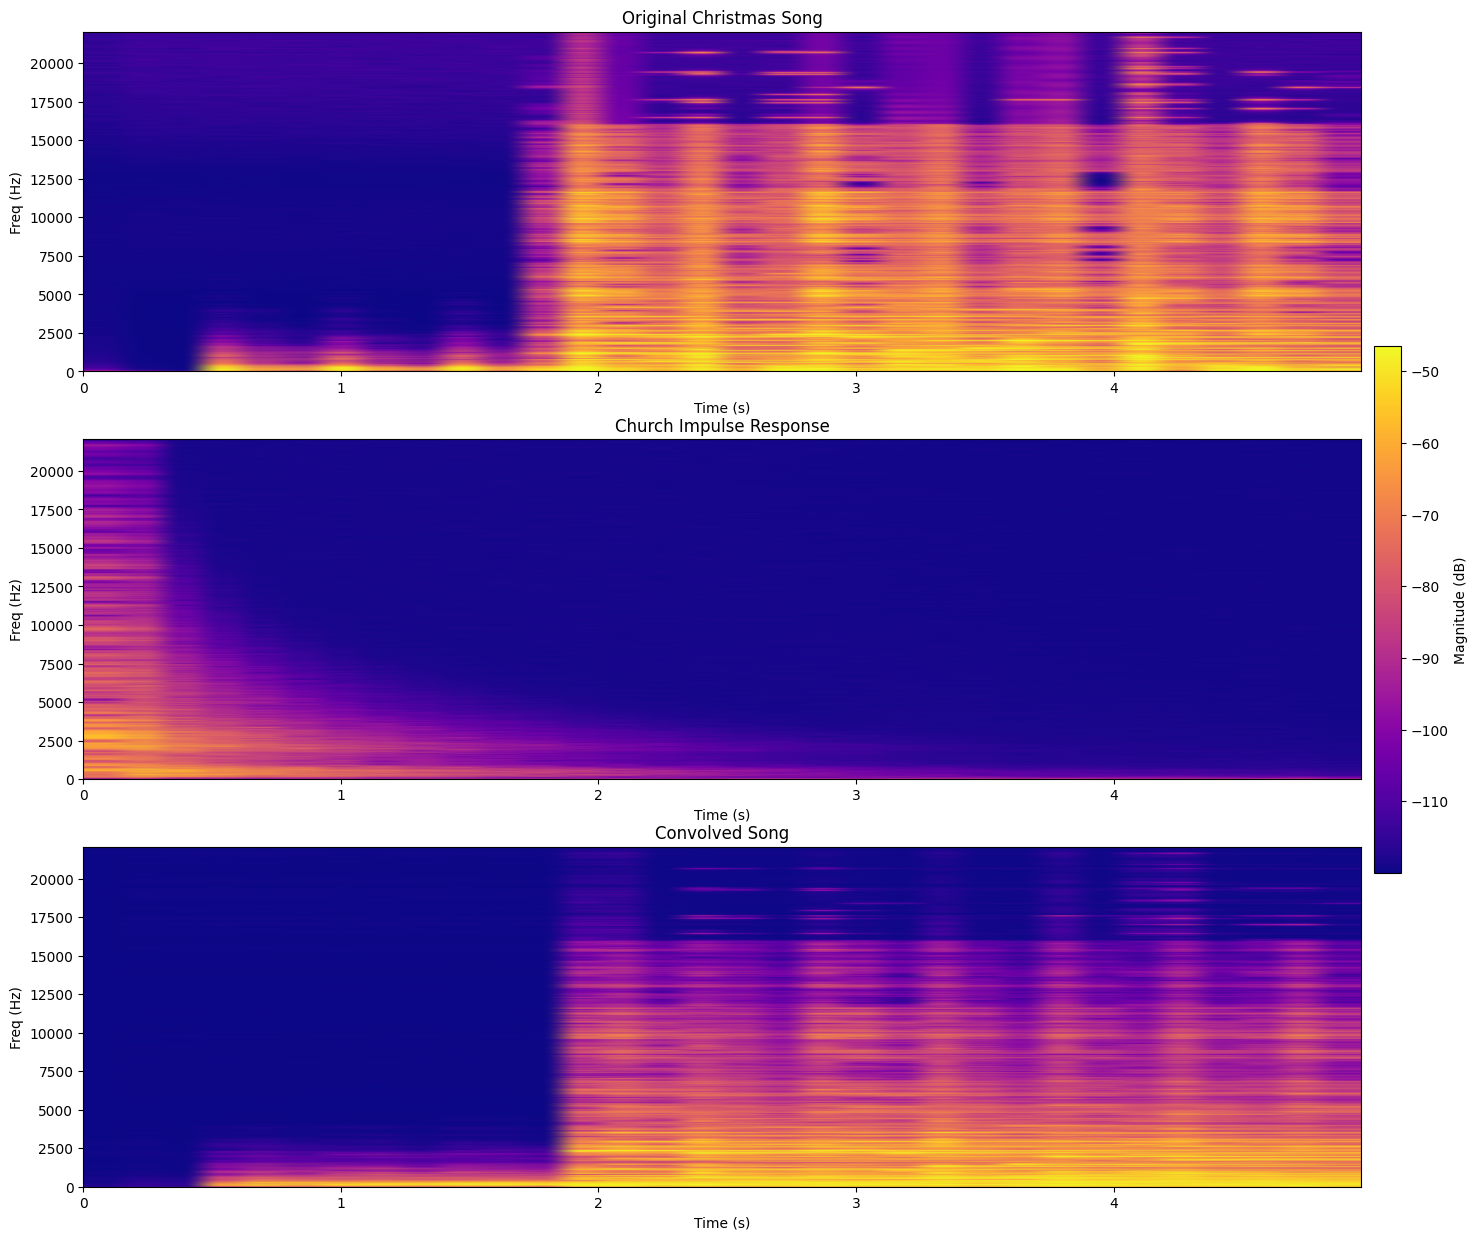

In [5]:
churchImpulse, samplerate = sf.read("../data/normalized_church_ir.wav")
christmasSong, samplerate = sf.read("../data/mini-christmas-song.wav")


t = np.linspace(0, len(christmasSong) + len(churchImpulse) / fs, len(christmasSong) + len(churchImpulse) - 1)
convolved_christmas = np.convolve(christmasSong, churchImpulse)
# sf.write("convolved_christmas.wav", convolved_christmas, fs)
segmentLength = int(samplerate / 100 * 32)
overlap = int(segmentLength / 2)
convolved_FreqArray, convolved_TimeArray, convolved_Stft = stft(convolved_christmas,fs= samplerate, nperseg=segmentLength, noverlap=overlap, window="hann")
impulse_FreqArray, impulse_TimeArray, impulse_Stft = stft(churchImpulse,fs= samplerate, nperseg=segmentLength, noverlap=overlap, window="hann")
christmasSong_FreqArray, christmasSong_TimeArray, christmasSong_Stft = stft(christmasSong,fs= samplerate, nperseg=segmentLength, noverlap=overlap, window="hann")
convolved_timeMask = convolved_TimeArray <= 5
impulse_timeMask = impulse_TimeArray <= 5
christmasSong_timeMask = christmasSong_TimeArray <= 5


convolved_magnitude = np.abs(convolved_Stft[:, convolved_timeMask])
impulse_magnitude = np.abs(impulse_Stft[:, impulse_timeMask])
christmasSong_magnitude = np.abs(christmasSong_Stft[:, christmasSong_timeMask])

convolved_magnitude_db = 20 * np.log10(convolved_magnitude + 1e-6)
impulse_magnitude_db = 20 * np.log10(impulse_magnitude + 1e-6)
christmasSong_magnitude_db = 20 * np.log10(christmasSong_magnitude + 1e-6)


vmin = np.percentile(convolved_magnitude_db, 5)
vmax = np.percentile(convolved_magnitude_db, 99)
convolved_magnitude_db_clipped = np.clip(convolved_magnitude_db, vmin, vmax)

christmasSong_magnitude_db_clipped = np.clip(christmasSong_magnitude_db, vmin, vmax)
impulse_magnitude_db_clipped = np.clip(impulse_magnitude_db, vmin, vmax)
convolved_magnitude_db_clipped = np.clip(convolved_magnitude_db, vmin, vmax)


fig, axs = plt.subplots(3, 1, figsize=(17, 15), sharex=False)

axs[0].imshow(christmasSong_magnitude_db_clipped,
              origin='lower',
              aspect='auto',
              extent=[christmasSong_TimeArray[christmasSong_timeMask][0], christmasSong_TimeArray[christmasSong_timeMask][-1], christmasSong_FreqArray[0], christmasSong_FreqArray[-1]],
              cmap='plasma')
axs[0].set_ylabel("Freq (Hz)")
axs[0].set_xlabel("Time (s)")
axs[0].set_title("Original Christmas Song")

axs[1].imshow(churchImpulse_magnitude_db_clipped := impulse_magnitude_db,
              origin='lower',
              aspect='auto',
              extent=[impulse_TimeArray[impulse_timeMask][0], impulse_TimeArray[impulse_timeMask][-1], impulse_FreqArray[0], impulse_FreqArray[-1]],
              cmap='plasma')
axs[1].set_ylabel("Freq (Hz)")
axs[1].set_xlabel("Time (s)")
axs[1].set_title("Church Impulse Response")

axs[2].imshow(convolved_magnitude_db_clipped,
              origin='lower',
              aspect='auto',
              extent=[convolved_TimeArray[convolved_timeMask][0], convolved_TimeArray[convolved_timeMask][-1], convolved_FreqArray[0], convolved_FreqArray[-1]],
              cmap='plasma')
axs[2].set_xlabel("Time (s)")
axs[2].set_ylabel("Freq (Hz)")
axs[2].set_title("Convolved Song")
cbar = fig.colorbar(axs[2].images[0], ax=axs, orientation='vertical', fraction=0.02, pad=0.01)
cbar.set_label("Magnitude (dB)")





# plt.xlabel("Time (s)")
# plt.ylabel("Frequency (Hz)")


# plt.imshow(convolved_magnitude_db_clipped,
#            origin='lower',
#            aspect='auto',
#            extent=[dataTimeArray[timeMask][0], dataTimeArray[timeMask][-1], convolved_FreqArray[0], convolved_FreqArray[-1]],
#            cmap='plasma')
# cbar = plt.colorbar()
# cbar.set_label("Magnitude (dB)")

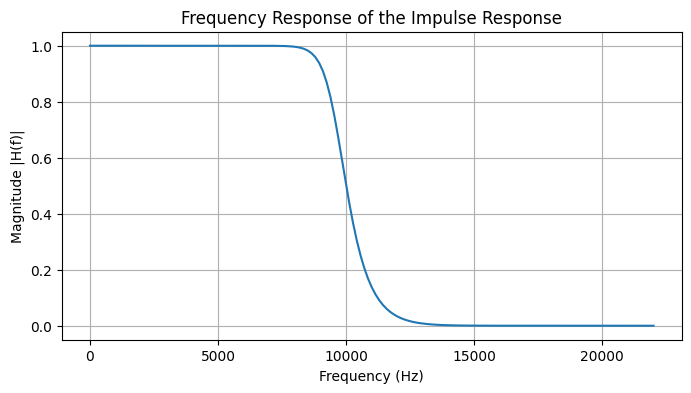

In [6]:
impulseResponse_dft = np.fft.rfft(hValues)
impulseResponse_freqs = np.fft.rfftfreq(len(hValues), d=1/44000)

#coeffs aus moodle laden

plt.figure(figsize=(8,4))
plt.plot(impulseResponse_freqs, np.abs(impulseResponse_dft))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude |H(f)|")
plt.title("Frequency Response of the Impulse Response")
plt.grid(True)
plt.show()

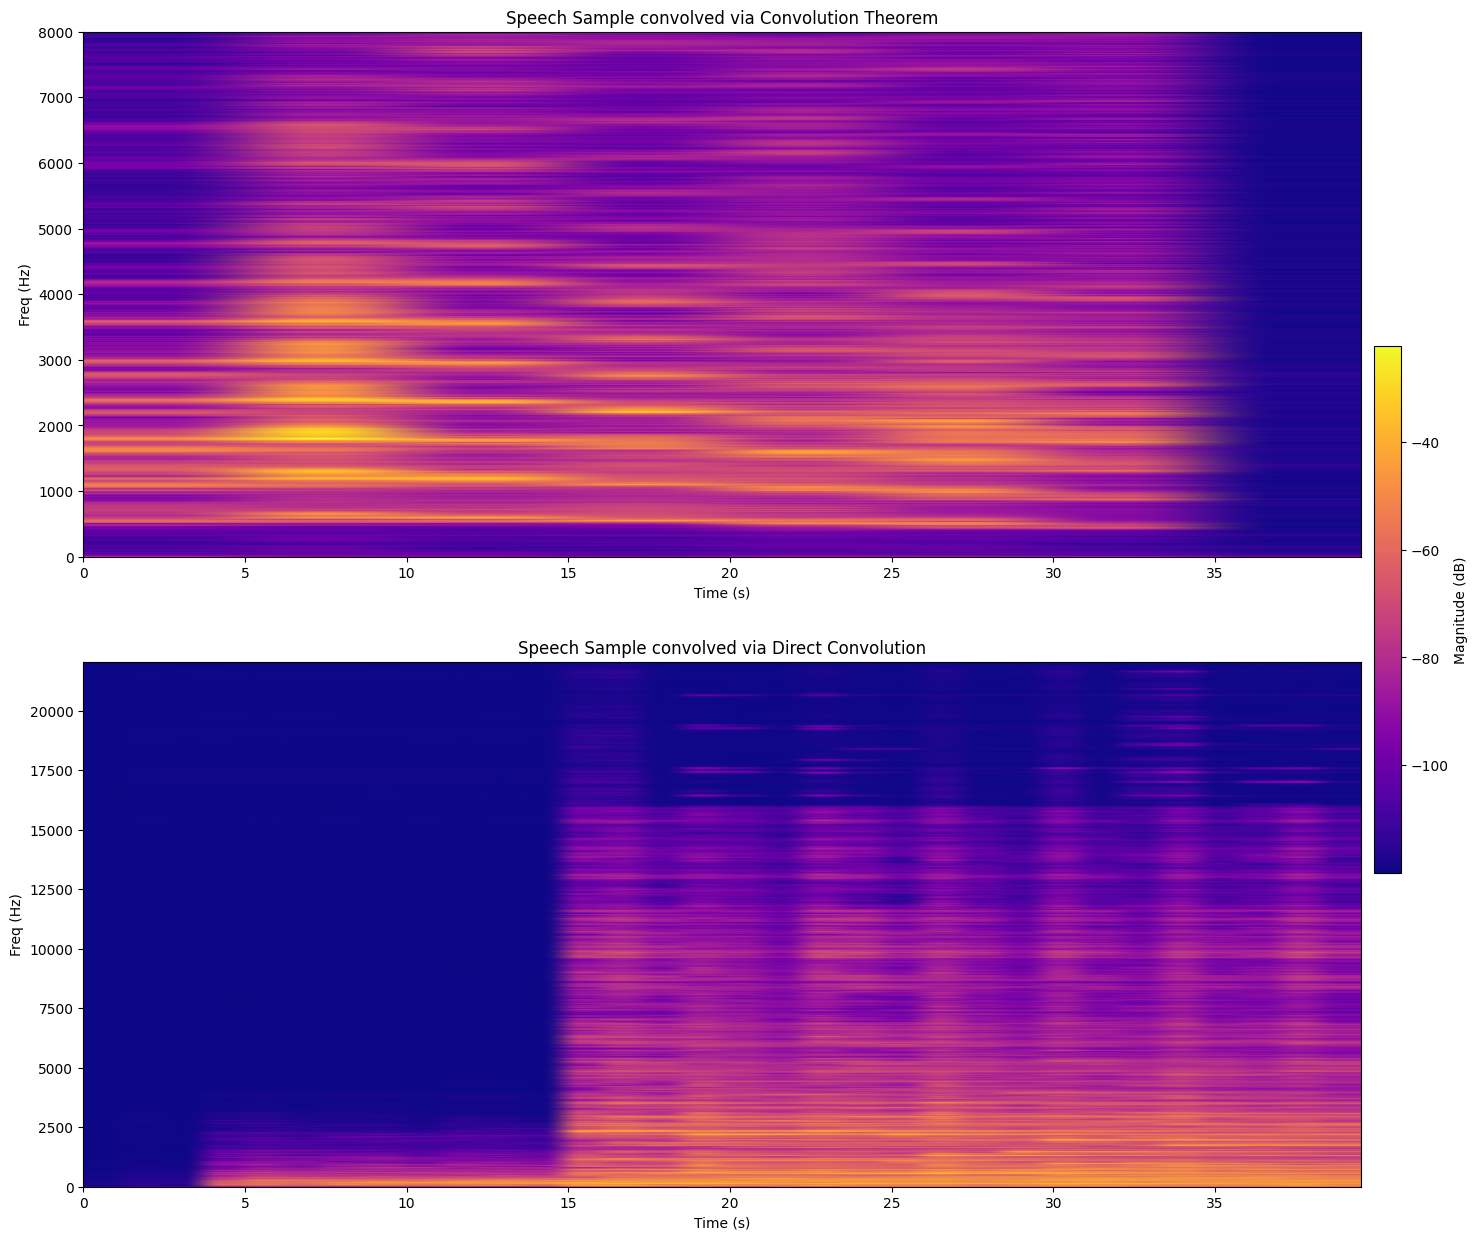

In [7]:

signal, fs = sf.read("../data/speech1.wav")
impulseResponse_dft = np.fft.rfft(hValues)
speech_dft = np.fft.rfft(signal)




N = len(x_test) + len(hValues) - 1




Lsig = len(signal)   # Länge des Signals
Lh = len(hValues)   # Länge der Impulsantwort
N = Lsig + Lh - 1
N = len(signal) + len(hValues) - 1
signal_padded = np.zeros(N)
h_padded = np.zeros(N)

signal_padded[:Lsig] = signal
h_padded[:Lh] = hValues

X = np.fft.fft(signal_padded)
H = np.fft.fft(h_padded)

# 5. Multiplikation im Frequenzbereich
Y = X * H


y = np.fft.ifft(Y).real



theorem_freq = np.fft.fftfreq(len(Y), d=1/fs)
theorem_magnitude_db = 20 * np.log10(np.abs(Y) + 1e-6)


f, t, Zxx = stft(y, fs=fs, nperseg=segmentLength, noverlap=overlap, window="hann")
magnitude_db = 20 * np.log10(np.abs(Zxx) + 1e-6)

fig, axs = plt.subplots(2, 1, figsize=(17, 15), sharex=False)



# ------------------------
# 5. Spektrogramm plotten
# ------------------------
axs[0].imshow(magnitude_db,  origin='lower',
              aspect='auto',
              extent=[convolved_TimeArray[0], convolved_TimeArray[-1], convolved_FreqArray[0], convolved_FreqArray[-1]],
              cmap='plasma')
axs[0].set_ylabel("Freq (Hz)")
axs[0].set_xlabel("Time (s)")
axs[0].set_title("Speech Sample convolved via Convolution Theorem")
axs[0].set_ylim([0, fs/2])


axs[1].imshow(convolved_magnitude_db,
              origin='lower',
              aspect='auto',
              extent=[convolved_TimeArray[0], convolved_TimeArray[-1], convolved_FreqArray[0], convolved_FreqArray[-1]],
              cmap='plasma')
axs[1].set_ylabel("Freq (Hz)")
axs[1].set_xlabel("Time (s)")
axs[1].set_title("Speech Sample convolved via Direct Convolution")




cbar = fig.colorbar(axs[1].images[0], ax=axs, orientation='vertical', fraction=0.02, pad=0.01)
cbar.set_label("Magnitude (dB)")



